<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: Background_subtract() for MIRI LRS SLIT
<span style="color:red"> **Instruments Affected**</span>: MIRI

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Get Documentaion String for Markdown Blocks](#markdown_from_docs) <br> [Loading Data](#data_ID) <br> [Run JWST Pipeline](#pipeline_ID) <br> [Create Figure or Print Output](#residual_ID) <br> [About This Notebook](#about_ID) <br>

</div>

<a id="imports_ID"></a>
# Imports
List the library imports and why they are relevant to this notebook.


* astropy.io for opening fits files
* jwst.datamodels for building model for JWST Pipeline
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot.plt to generate plot
* shutil, glob for basic OS operations

* pysiaf for retrieving SIAF information
* miricoord for coordinate transformations
* ci_watson for retrieval from artifactory


[Top of Page](#title_ID)

In [1]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /tmp/crds_cache


In [2]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import scipy.stats as stats
import numpy as np
from glob import glob
import shutil
import os
import logging

%matplotlib inline

from jwst.pipeline import Spec2Pipeline, Detector1Pipeline
from jwst.assign_wcs import AssignWcsStep
from jwst.background import BackgroundStep
from jwst import datamodels
from jwst.datamodels import ImageModel
import pysiaf
import miricoord.imager.mirim_tools as mt


from ci_watson.artifactory_helpers import get_bigdata

<a id="intro_ID"></a>
# Introduction


For this test we are using the background subtraction step for MIRI LRS slit data. For more information on the pipeline step visit the links below. 

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/background/description.html

Pipeline code: https://github.com/spacetelescope/jwst/blob/master/jwst/background/



### Defining Term
Here is where you will define terms or acronymns that may not be known a general audience (ie a new employee to the institute or an external user). For example

JWST: James Webb Space Telescope
MIRI: Mid-Infrared Instrument
LRS: Low Resolution Spectrometer


[Top of Page](#title_ID)

<a id="data_ID"></a>
# Loading Data and initial processing

We are using here a simulated LRS slit observation, generated with MIRISim v2.3.0 (as of Dec 2020). It is a simple along-slit-nodded observation of a point source (the input was modelled on the flux calibrator BD+60). LRS slit observations cover the full array. 

[Top of Page](#title_ID)

In [3]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
data_dir = TemporaryDirectory()
os.chdir(data_dir.name)

In [4]:
Slitfile1 = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_spec2',
                                    'spec2_miri_test',
                                    'miri_lrs_slit_pt_nod1_v2.3.fits')
 
Slitfile2 = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_spec2',
                                    'spec2_miri_test',
                                    'miri_lrs_slit_pt_nod2_v2.3.fits')

files = [Slitfile1, Slitfile2]

Now run pipeline stage Detector1() and step Assignwcs() for initial processing, on both files.

In [5]:
det1_out = []
nods = []
for ff in files:
    det1 = Detector1Pipeline.call(ff, save_results=True)
    if 'nod1' in ff:
        nodno = 'nod1'
    else:
        nodno = 'nod2'
    det1_out.append(det1)
    nods.append(nodno)

2022-09-19 15:31:01,297 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /tmp/crds_cache/references/jwst/miri/jwst_miri_pars-detector1pipeline_0001.asdf


2022-09-19 15:31:01,316 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-09-19 15:31:01,317 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-09-19 15:31:01,318 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-09-19 15:31:01,320 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-09-19 15:31:01,321 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-09-19 15:31:01,322 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-09-19 15:31:01,323 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-09-19 15:31:01,324 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-09-19 15:31:01,325 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-09-19 15:31:01,326 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-09-19 15:31:01,328 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-09-19 15:31:01,329 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-09-19 15:31:01,330 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-09-19 15:31:01,332 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-09-19 15:31:01,333 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-09-19 15:31:01,334 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-09-19 15:31:01,336 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-09-19 15:31:01,454 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph/miri_lrs_slit_pt_nod1_v2.3.fits',).


2022-09-19 15:31:01,463 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-09-19 15:31:01,666 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'miri_lrs_slit_pt_nod1_v2.3.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-09-19 15:31:01,670 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_dark_0058.fits'.


2022-09-19 15:31:01,671 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits'.


2022-09-19 15:31:01,671 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_linearity_0024.fits'.


2022-09-19 15:31:01,672 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_mask_0028.fits'.


2022-09-19 15:31:01,673 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-09-19 15:31:01,673 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits'.


2022-09-19 15:31:01,674 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-09-19 15:31:01,674 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_reset_0047.fits'.


2022-09-19 15:31:01,675 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_rscd_0014.fits'.


2022-09-19 15:31:01,675 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits'.


2022-09-19 15:31:01,676 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-09-19 15:31:01,676 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-09-19 15:31:01,676 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-09-19 15:31:01,677 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-09-19 15:31:02,006 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-09-19 15:31:02,008 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph'}


2022-09-19 15:31:02,125 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-09-19 15:31:02,127 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-09-19 15:31:02,129 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-09-19 15:31:02,235 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-09-19 15:31:02,236 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph'}


2022-09-19 15:31:02,274 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_mask_0028.fits


2022-09-19 15:31:02,558 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-09-19 15:31:02,664 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-09-19 15:31:02,666 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph', 'n_pix_grow_sat': 1}


2022-09-19 15:31:02,687 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits


2022-09-19 15:31:03,596 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2022-09-19 15:31:03,610 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-09-19 15:31:03,619 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-09-19 15:31:03,736 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-09-19 15:31:03,738 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph'}


2022-09-19 15:31:03,738 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-09-19 15:31:03,741 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-09-19 15:31:03,846 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-09-19 15:31:03,848 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph'}


2022-09-19 15:31:03,970 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-09-19 15:31:04,080 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-09-19 15:31:04,082 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph'}


2022-09-19 15:31:04,204 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-09-19 15:31:04,307 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-09-19 15:31:04,309 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph'}


2022-09-19 15:31:04,330 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_reset_0047.fits


2022-09-19 15:31:04,686 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-09-19 15:31:04,821 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-09-19 15:31:04,823 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph'}


2022-09-19 15:31:04,845 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_linearity_0024.fits


2022-09-19 15:31:05,339 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-09-19 15:31:05,447 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-09-19 15:31:05,449 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph', 'type': 'baseline'}


2022-09-19 15:31:05,471 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_rscd_0014.fits


2022-09-19 15:31:05,632 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-09-19 15:31:05,743 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-09-19 15:31:05,745 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph', 'dark_output': None}


2022-09-19 15:31:05,767 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_dark_0058.fits


2022-09-19 15:31:07,497 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=10, nframes=1, groupgap=0


2022-09-19 15:31:07,498 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-09-19 15:31:08,275 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-09-19 15:31:08,401 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-09-19 15:31:08,403 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-09-19 15:31:08,521 - stpipe.Detector1Pipeline.refpix - INFO - MIRI full frame data


2022-09-19 15:31:08,522 - stpipe.Detector1Pipeline.refpix - INFO - The following parameter is valid for this mode:


2022-09-19 15:31:08,522 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2022-09-19 15:31:08,523 - stpipe.Detector1Pipeline.refpix - INFO - The following parameters are not applicable and are ignored:


2022-09-19 15:31:08,523 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = False


2022-09-19 15:31:08,523 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = False


2022-09-19 15:31:08,524 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = False


2022-09-19 15:31:08,524 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = False


2022-09-19 15:31:08,527 - stpipe.Detector1Pipeline.refpix - INFO - Subtracting initial read from each integration


2022-09-19 15:31:08,782 - stpipe.Detector1Pipeline.refpix - INFO - Adding initial read back in


2022-09-19 15:31:08,835 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-09-19 15:31:08,940 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-09-19 15:31:08,942 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-09-19 15:31:08,952 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-09-19 15:31:08,964 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /tmp/crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits


2022-09-19 15:31:09,001 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /tmp/crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits


2022-09-19 15:31:09,203 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-09-19 15:31:09,249 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-09-19 15:31:10,172 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28384 pixels with at least one CR from five or more groups.


2022-09-19 15:31:10,174 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-09-19 15:31:10,174 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-09-19 15:31:13,964 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-09-19 15:31:14,928 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12669 pixels with at least one CR from five or more groups.


2022-09-19 15:31:14,929 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-09-19 15:31:14,929 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-09-19 15:31:16,350 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 7.14635 sec


2022-09-19 15:31:16,354 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.401801


2022-09-19 15:31:16,359 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-09-19 15:31:16,467 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-09-19 15:31:16,468 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-09-19 15:31:16,501 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /tmp/crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits


2022-09-19 15:31:16,502 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /tmp/crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits


2022-09-19 15:31:16,553 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-09-19 15:31:16,554 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-09-19 15:31:16,646 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-09-19 15:31:16,647 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-09-19 15:31:28,106 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-09-19 15:31:28,111 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 2


2022-09-19 15:31:28,206 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-09-19 15:31:28,346 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-09-19 15:31:28,348 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph'}


2022-09-19 15:31:28,386 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-09-19 15:31:28,387 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-09-19 15:31:28,393 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-09-19 15:31:28,498 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-09-19 15:31:28,500 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph'}


2022-09-19 15:31:28,540 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-09-19 15:31:28,540 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-09-19 15:31:28,545 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-09-19 15:31:28,637 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_rateints.fits


2022-09-19 15:31:28,638 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-09-19 15:31:28,639 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0977.pmap


2022-09-19 15:31:28,703 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_rate.fits


2022-09-19 15:31:28,704 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-09-19 15:31:28,883 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /tmp/crds_cache/references/jwst/miri/jwst_miri_pars-detector1pipeline_0001.asdf


2022-09-19 15:31:28,899 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-09-19 15:31:28,900 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-09-19 15:31:28,901 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-09-19 15:31:28,903 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-09-19 15:31:28,904 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-09-19 15:31:28,905 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-09-19 15:31:28,906 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-09-19 15:31:28,907 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-09-19 15:31:28,908 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-09-19 15:31:28,909 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-09-19 15:31:28,910 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-09-19 15:31:28,911 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-09-19 15:31:28,912 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-09-19 15:31:28,913 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-09-19 15:31:28,915 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-09-19 15:31:28,916 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-09-19 15:31:28,917 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-09-19 15:31:29,024 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph/miri_lrs_slit_pt_nod2_v2.3.fits',).


2022-09-19 15:31:29,035 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-09-19 15:31:29,191 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'miri_lrs_slit_pt_nod2_v2.3.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-09-19 15:31:29,195 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_dark_0058.fits'.


2022-09-19 15:31:29,196 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits'.


2022-09-19 15:31:29,196 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_linearity_0024.fits'.


2022-09-19 15:31:29,197 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_mask_0028.fits'.


2022-09-19 15:31:29,198 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-09-19 15:31:29,198 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits'.


2022-09-19 15:31:29,199 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-09-19 15:31:29,199 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_reset_0047.fits'.


2022-09-19 15:31:29,200 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_rscd_0014.fits'.


2022-09-19 15:31:29,200 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits'.


2022-09-19 15:31:29,201 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-09-19 15:31:29,201 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-09-19 15:31:29,201 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-09-19 15:31:29,202 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-09-19 15:31:29,482 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-09-19 15:31:29,484 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph'}


2022-09-19 15:31:29,574 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-09-19 15:31:29,575 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-09-19 15:31:29,577 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-09-19 15:31:29,687 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-09-19 15:31:29,689 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph'}


2022-09-19 15:31:29,710 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_mask_0028.fits


2022-09-19 15:31:29,980 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-09-19 15:31:30,114 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-09-19 15:31:30,116 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph', 'n_pix_grow_sat': 1}


2022-09-19 15:31:30,138 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits


2022-09-19 15:31:31,042 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2022-09-19 15:31:31,057 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-09-19 15:31:31,066 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-09-19 15:31:31,179 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-09-19 15:31:31,181 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph'}


2022-09-19 15:31:31,181 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-09-19 15:31:31,185 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-09-19 15:31:31,293 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-09-19 15:31:31,294 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph'}


2022-09-19 15:31:31,417 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-09-19 15:31:31,530 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-09-19 15:31:31,532 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph'}


2022-09-19 15:31:31,631 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-09-19 15:31:31,750 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-09-19 15:31:31,751 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph'}


2022-09-19 15:31:31,775 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_reset_0047.fits


2022-09-19 15:31:32,114 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-09-19 15:31:32,230 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-09-19 15:31:32,232 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph'}


2022-09-19 15:31:32,253 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_linearity_0024.fits


2022-09-19 15:31:32,695 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-09-19 15:31:32,810 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-09-19 15:31:32,812 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph', 'type': 'baseline'}


2022-09-19 15:31:32,833 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_rscd_0014.fits


2022-09-19 15:31:32,997 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-09-19 15:31:33,116 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-09-19 15:31:33,118 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph', 'dark_output': None}


2022-09-19 15:31:33,141 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_dark_0058.fits


2022-09-19 15:31:34,560 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=10, nframes=1, groupgap=0


2022-09-19 15:31:34,560 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-09-19 15:31:35,283 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-09-19 15:31:35,397 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-09-19 15:31:35,398 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-09-19 15:31:35,514 - stpipe.Detector1Pipeline.refpix - INFO - MIRI full frame data


2022-09-19 15:31:35,515 - stpipe.Detector1Pipeline.refpix - INFO - The following parameter is valid for this mode:


2022-09-19 15:31:35,515 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2022-09-19 15:31:35,516 - stpipe.Detector1Pipeline.refpix - INFO - The following parameters are not applicable and are ignored:


2022-09-19 15:31:35,516 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = False


2022-09-19 15:31:35,516 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = False


2022-09-19 15:31:35,517 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = False


2022-09-19 15:31:35,517 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = False


2022-09-19 15:31:35,518 - stpipe.Detector1Pipeline.refpix - INFO - Subtracting initial read from each integration


2022-09-19 15:31:35,762 - stpipe.Detector1Pipeline.refpix - INFO - Adding initial read back in


2022-09-19 15:31:35,814 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-09-19 15:31:35,920 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-09-19 15:31:35,921 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-09-19 15:31:35,931 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-09-19 15:31:35,943 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /tmp/crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits


2022-09-19 15:31:35,977 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /tmp/crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits


2022-09-19 15:31:36,147 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-09-19 15:31:36,189 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-09-19 15:31:37,080 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28153 pixels with at least one CR from five or more groups.


2022-09-19 15:31:37,081 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-09-19 15:31:37,082 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-09-19 15:31:40,906 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-09-19 15:31:41,870 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12958 pixels with at least one CR from five or more groups.


2022-09-19 15:31:41,871 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-09-19 15:31:41,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-09-19 15:31:43,334 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 7.1855 sec


2022-09-19 15:31:43,337 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.405875


2022-09-19 15:31:43,342 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-09-19 15:31:43,460 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-09-19 15:31:43,462 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-09-19 15:31:43,494 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /tmp/crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits


2022-09-19 15:31:43,495 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /tmp/crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits


2022-09-19 15:31:43,545 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-09-19 15:31:43,545 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-09-19 15:31:43,636 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-09-19 15:31:43,637 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-09-19 15:31:55,488 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-09-19 15:31:55,490 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 2


2022-09-19 15:31:55,579 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-09-19 15:31:55,712 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-09-19 15:31:55,713 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph'}


2022-09-19 15:31:55,751 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-09-19 15:31:55,752 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-09-19 15:31:55,756 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-09-19 15:31:55,856 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-09-19 15:31:55,858 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpeo3occph'}


2022-09-19 15:31:55,897 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-09-19 15:31:55,897 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-09-19 15:31:55,902 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-09-19 15:31:55,990 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_rateints.fits


2022-09-19 15:31:55,991 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-09-19 15:31:55,992 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0977.pmap


2022-09-19 15:31:56,056 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_rate.fits


2022-09-19 15:31:56,056 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


In [6]:
awcs_out = []

for dd in det1_out:
    awcs = AssignWcsStep.call(dd, save_results=True)
    awcs_out.append(awcs)

2022-09-19 15:31:56,074 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-09-19 15:31:56,177 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-09-19 15:31:56,179 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-09-19 15:31:56,451 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_lrs-fixedslit pipeline with references {'distortion': '/tmp/crds_cache/references/jwst/miri/jwst_miri_distortion_0028.asdf', 'filteroffset': None, 'specwcs': '/tmp/crds_cache/references/jwst/miri/jwst_miri_specwcs_0003.fits', 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-09-19 15:31:56,539 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  0.000379612 -0.000035778 0.000379612 0.000080412 359.999082432 0.000080412 359.999082432 -0.000035778


2022-09-19 15:31:56,540 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.000379612 -0.000035778 0.000379612 0.000080412 359.999082432 0.000080412 359.999082432 -0.000035778


2022-09-19 15:31:56,541 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-09-19 15:31:56,554 - stpipe.AssignWcsStep - INFO - Results used CRDS context: jwst_0977.pmap


2022-09-19 15:31:56,729 - stpipe.AssignWcsStep - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_assignwcsstep.fits


2022-09-19 15:31:56,730 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2022-09-19 15:31:56,739 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-09-19 15:31:56,858 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-09-19 15:31:56,860 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-09-19 15:31:57,113 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_lrs-fixedslit pipeline with references {'distortion': '/tmp/crds_cache/references/jwst/miri/jwst_miri_distortion_0028.asdf', 'filteroffset': None, 'specwcs': '/tmp/crds_cache/references/jwst/miri/jwst_miri_specwcs_0003.fits', 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-09-19 15:31:57,199 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  0.000903013 -0.000079284 0.000903013 0.000036907 359.999605833 0.000036907 359.999605833 -0.000079284


2022-09-19 15:31:57,200 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.000903013 -0.000079284 0.000903013 0.000036907 359.999605833 0.000036907 359.999605833 -0.000079284


2022-09-19 15:31:57,200 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-09-19 15:31:57,214 - stpipe.AssignWcsStep - INFO - Results used CRDS context: jwst_0977.pmap


2022-09-19 15:31:57,385 - stpipe.AssignWcsStep - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_assignwcsstep.fits


2022-09-19 15:31:57,386 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


In [7]:
print(awcs_out)
print(nods)

[<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_assignwcsstep.fits>, <ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_assignwcsstep.fits>]
['nod1', 'nod2']


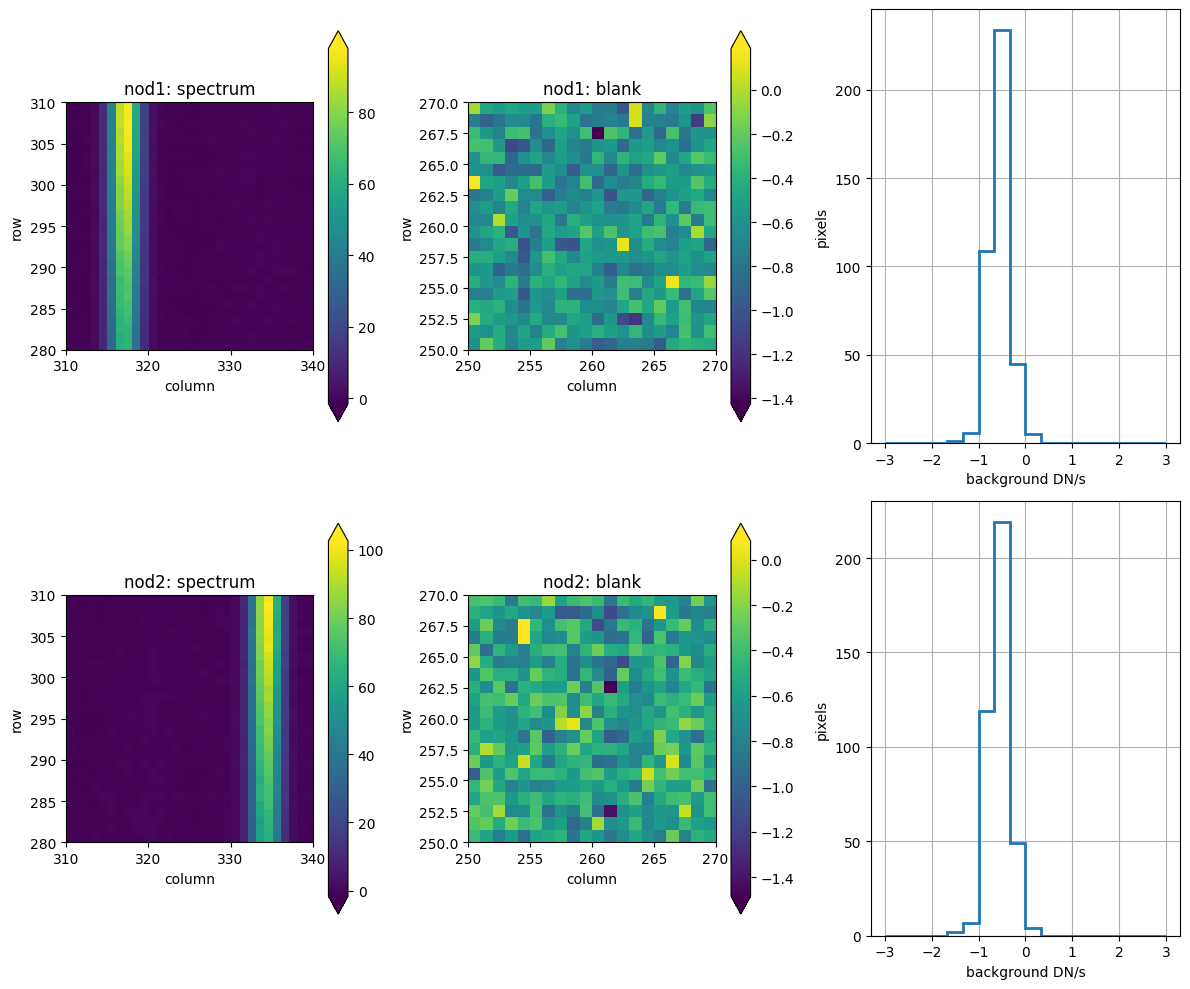

In [8]:
hdus = []
sci_ims = []
#nod_ims = ['nod 1', 'nod 2']
reg_spec = {'nod1':{'row1': 280, 'row2': 310, 'col1': 310, 'col2': 340}, 
            'nod2': {'row1': 280, 'row2': 310, 'col1': 310, 'col2': 340}}
reg_blank = {'nod1': {'row1': 250, 'row2': 270, 'col1': 250, 'col2': 270}, 
             'nod2': {'row1': 250, 'row2': 270, 'col1': 250, 'col2': 270}}


fig, ax = plt.subplots(ncols=3, nrows=2, figsize=[12,10])

for i,(aa, nn) in enumerate(zip(awcs_out, nods)):
    im = aa.data
    # PLOT THE TWO NODS: SPECTRUM AND BLANK REGION
    #print(i, aa, nn)
    
    implt0 = ax[i,0].imshow(im[reg_spec[nn]['row1']:reg_spec[nn]['row2'], reg_spec[nn]['col1']:reg_spec[nn]['col2']], extent=[reg_spec[nn]['col1'], reg_spec[nn]['col2'], reg_spec[nn]['row1'], reg_spec[nn]['row2']],origin='lower', interpolation='None')
    ax[i,0].set_xlabel('column')
    ax[i,0].set_ylabel('row')
    ax[i,0].set_title('{}: spectrum'.format(nn))
    cbar = fig.colorbar(implt0, extend='both', shrink=0.9, ax=ax[i,0])
    
    implt1 = ax[i,1].imshow(im[reg_blank[nn]['row1']:reg_blank[nn]['row2'], reg_blank[nn]['col1']:reg_blank[nn]['col2']], extent=[reg_blank[nn]['col1'], reg_blank[nn]['col2'], reg_blank[nn]['row1'], reg_blank[nn]['row2']],origin='lower', interpolation='None')
    ax[i,1].set_xlabel('column')
    ax[i,1].set_ylabel('row')
    ax[i,1].set_title('{}: blank'.format(nn))
    cbar = fig.colorbar(implt1, extend='both', shrink=0.9, ax=ax[i,1])
    
    hbins = np.linspace(-3., +3., 19)
    implt2 = ax[i,2].hist(np.ravel(im[reg_blank[nn]['row1']:reg_blank[nn]['row2'], reg_blank[nn]['col1']:reg_blank[nn]['col2']]), bins=hbins, histtype='step', lw=2)
    ax[i,2].set_xlabel('background DN/s')
    ax[i,2].set_ylabel('pixels')
    ax[i,2].grid()
    
    fig.tight_layout()

## Manual subtraction check

Let's subtract nod 2 from nod 1, and vice versa, to act as comparison data for the pipeline step.

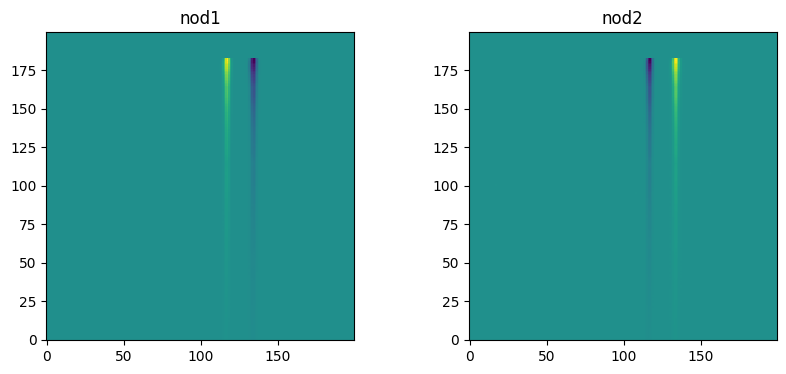

In [9]:
subcomp = []
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[10,4])

for i, aa in enumerate(awcs_out):
    if (i==0):
        bgr = awcs_out[1]
    else:
        bgr = awcs_out[0]
    
    sub = aa.data - bgr.data
    subcomp.append(sub)
    ax[i].imshow(sub[200:400, 200:400], origin='lower', interpolation='None')
    ax[i].set_title('{}'.format(nods[i]))            

## Pipeline step: BackgroundStep.call()

Now we run the background subtraction step. Nod 2 is the background for Nod 1, and vice versa. So we should end up with 2 outputs, each with a positive and negative spectral trace, and the background subtracted. 

This is the first method we try, using BackgroundStep.call(). This takes the following input:
- science file
- background file, or list of background files

i.e. this does _not_ take an association as input. We do the following in this next step:

* create an instance of the step
* set the output directory
* set up the logger to create an output logfile
* call the step, and save the output to the output directory

In [10]:
bgrstep = BackgroundStep()
subims = []
outdir = './point_slit_2dither/output_files/'

for i, aa in enumerate(awcs_out):
    print(i)

    if (i==0):
        bgr = awcs_out[1]
    elif (i==1):
        bgr = awcs_out[0]
    subim = bgrstep.call(aa, [bgr], save_results=True)
    subims.append(subim)

2022-09-19 15:31:58,491 - stpipe.BackgroundStep - INFO - BackgroundStep instance created.


2022-09-19 15:31:58,500 - stpipe.BackgroundStep - INFO - BackgroundStep instance created.


2022-09-19 15:31:58,626 - stpipe.BackgroundStep - INFO - Step BackgroundStep running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_assignwcsstep.fits>, [<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_assignwcsstep.fits>]).


2022-09-19 15:31:58,627 - stpipe.BackgroundStep - INFO - Step BackgroundStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-09-19 15:31:58,634 - stpipe.BackgroundStep - INFO - Accumulate bkg from <ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_assignwcsstep.fits>


0


2022-09-19 15:31:59,080 - stpipe.BackgroundStep - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_backgroundstep.fits


2022-09-19 15:31:59,080 - stpipe.BackgroundStep - INFO - Step BackgroundStep done


2022-09-19 15:31:59,090 - stpipe.BackgroundStep - INFO - BackgroundStep instance created.


2022-09-19 15:31:59,219 - stpipe.BackgroundStep - INFO - Step BackgroundStep running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_assignwcsstep.fits>, [<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_assignwcsstep.fits>]).


2022-09-19 15:31:59,221 - stpipe.BackgroundStep - INFO - Step BackgroundStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-09-19 15:31:59,228 - stpipe.BackgroundStep - INFO - Accumulate bkg from <ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_assignwcsstep.fits>


1


2022-09-19 15:31:59,653 - stpipe.BackgroundStep - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_backgroundstep.fits


2022-09-19 15:31:59,654 - stpipe.BackgroundStep - INFO - Step BackgroundStep done


Compare the output against the manual check.

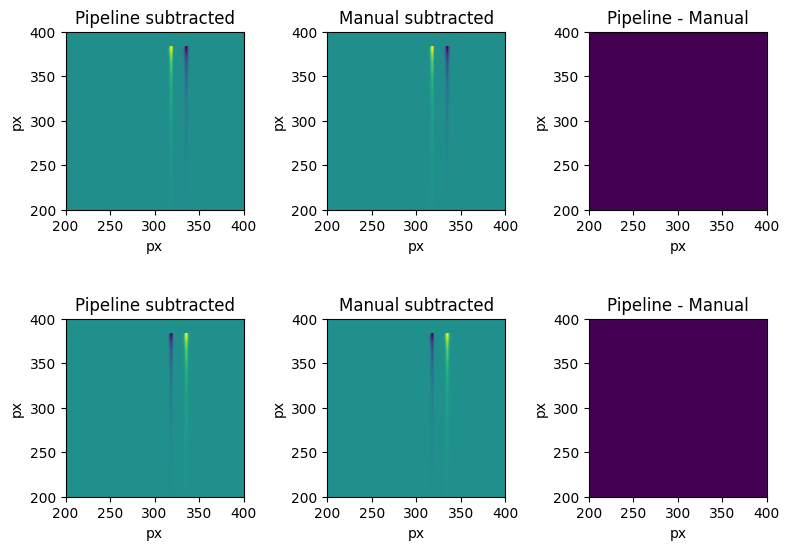

In [11]:
fig, _ax = plt.subplots(ncols=3, nrows=2, figsize=[8,6])
ax = _ax.flatten()

reg = [200, 400]

for i, (pp, cc) in enumerate(zip(subims, subcomp)):
    j = i*3
    ax[j].imshow(pp.data[reg[0]:reg[1], reg[0]:reg[1]], origin='lower', interpolation='None', extent=[reg[0], reg[1], reg[0], reg[1]])
    ax[j].set_title('Pipeline subtracted')
    ax[j].set_xlabel('px')
    ax[j].set_ylabel('px')
    ax[j+1].imshow(cc[reg[0]:reg[1], reg[0]:reg[1]], origin='lower', interpolation='None', extent=[reg[0], reg[1], reg[0], reg[1]])
    ax[j+1].set_title('Manual subtracted')
    ax[j+1].set_xlabel('px')
    ax[j+1].set_ylabel('px')
    ax[j+2].imshow(pp.data[reg[0]:reg[1], reg[0]:reg[1]]-cc[reg[0]:reg[1], reg[0]:reg[1]], origin='lower', interpolation='None', extent=[reg[0], reg[1], reg[0], reg[1]])
    ax[j+2].set_title('Pipeline - Manual')
    ax[j+2].set_xlabel('px')
    ax[j+2].set_ylabel('px')
    
    
    fig.tight_layout()

Compare histograms of the blank regions of science frames and subtracted frames. The two subtracted histograms should be the same and centred close(r) to zero than the background regions in the science frames.

MEAN VALUE OF BLANK SKY REGION BEFORE SUBTRACTION, nod1 = -0.5676
MEAN VALUE OF BLANK SKY REGION BEFORE SUBTRACTION, nod2 = -0.5677
MEAN VALUE OF BLANK SKY REGION AFTER SUBTRACTION, PIPELINE SUBTRACTION, nod2 = 0.0001
MEAN VALUE OF BLANK SKY REGION AFTER SUBTRACTION, MANUAL SUBTRACTION, nod2 = 0.0001
MEAN VALUE OF BLANK SKY REGION AFTER SUBTRACTION, PIPELINE SUBTRACTION, nod2 = -0.0001
MEAN VALUE OF BLANK SKY REGION AFTER SUBTRACTION, MANUAL SUBTRACTION, nod2 = -0.0001


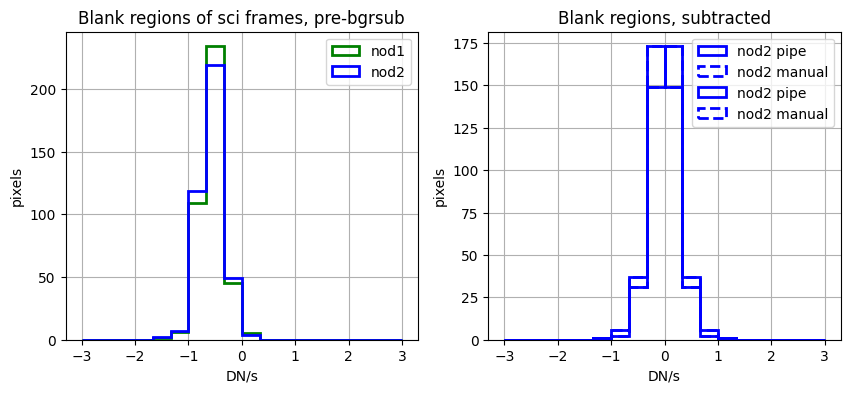

In [12]:
fig, _ax = plt.subplots(nrows=1, ncols=2, figsize=[10,4])
ax = _ax.flatten()

presub_mean = np.zeros(2, dtype=float)
sub_mean = np.zeros_like(presub_mean)
sub_mean_man = np.zeros_like(presub_mean)


for i, (aa, nn) in enumerate(zip(awcs_out, nods)):
    if '1' in nn:
        lab = 'nod1'
        cc = 'g'
    else:
        lab = 'nod2'
        cc = 'b'
    ax[0].hist(np.ravel(aa.data[reg_blank[lab]['row1']:reg_blank[lab]['row2'], reg_blank[lab]['col1']:reg_blank[lab]['col2']]), bins=hbins, histtype='step', lw=2, color=cc, label=lab)
    ax[0].legend(prop={'size': 10})
    ax[0].set_title('Blank regions of sci frames, pre-bgrsub')
    ax[0].set_xlabel('DN/s')
    ax[0].set_ylabel('pixels')
    ax[0].grid(True)
    
    print('MEAN VALUE OF BLANK SKY REGION BEFORE SUBTRACTION, {0} = {1:.4f}'.format(lab, np.mean(aa.data[reg_blank[lab]['row1']:reg_blank[lab]['row2'], reg_blank[lab]['col1']:reg_blank[lab]['col2']])))
    
    presub_mean[i] = np.mean(aa.data[reg_blank[lab]['row1']:reg_blank[lab]['row2'], reg_blank[lab]['col1']:reg_blank[lab]['col2']])
    
    



for pp, cc in zip(subims, subcomp):
    if 'seq1' in pp.meta.filename:
        lab = 'nod1'
        col ='g'
    else:
        lab = 'nod2'
        col = 'b'
    ax[1].hist(np.ravel(pp.data[reg_blank[lab]['row1']:reg_blank[lab]['row2'], reg_blank[lab]['col1']:reg_blank[lab]['col2']]), bins=hbins, histtype='step', lw=2, color=col, ls = '-', label=lab+' pipe')
    ax[1].hist(np.ravel(cc[reg_blank[lab]['row1']:reg_blank[lab]['row2'], reg_blank[lab]['col1']:reg_blank[lab]['col2']]), bins=hbins, histtype='step', lw=2, color=col, ls = '--', label=lab+' manual')
    ax[1].legend(prop={'size': 10})
    ax[1].set_title('Blank regions, subtracted')
    ax[1].set_xlabel('DN/s')
    ax[1].set_ylabel('pixels')
    ax[1].grid(True)
    
    print('MEAN VALUE OF BLANK SKY REGION AFTER SUBTRACTION, PIPELINE SUBTRACTION, {0} = {1:.4f}'.format(lab, np.mean(pp.data[reg_blank[lab]['row1']:reg_blank[lab]['row2'], reg_blank[lab]['col1']:reg_blank[lab]['col2']])))
    print('MEAN VALUE OF BLANK SKY REGION AFTER SUBTRACTION, MANUAL SUBTRACTION, {0} = {1:.4f}'.format(lab, np.mean(cc[reg_blank[lab]['row1']:reg_blank[lab]['row2'], reg_blank[lab]['col1']:reg_blank[lab]['col2']])))
    
    sub_mean[i] = np.mean(pp.data[reg_blank[lab]['row1']:reg_blank[lab]['row2'], reg_blank[lab]['col1']:reg_blank[lab]['col2']])
    sub_mean_man[i] = np.mean(cc[reg_blank[lab]['row1']:reg_blank[lab]['row2'], reg_blank[lab]['col1']:reg_blank[lab]['col2']])

Now run the following checks:
* pipeline subtracted and manual check version should be almost identical
* the pipeline subtracted version should have a mean that is closer to zero than the pre-subtracted version (in absolute value)

If these assert statements PASS and plots back the findings up, the test is successful.


In [13]:
try:
    assert np.allclose(sub_mean, sub_mean_man)
except:
    print("AssertionError: Pipeline subtraction and manual check don't appear to match")
    
try:    
    assert np.abs(presub_mean[0]) > np.abs(sub_mean[0])
except:    
    print("AssertionError: Post-background subtraction values appear to be higher than pre-subtraction; this is unexpected.")

try:    
    assert np.abs(presub_mean[1]) > np.abs(sub_mean[1])
except:
    print("AssertionError: Post-background subtraction values appear to be higher than pre-subtraction; this is unexpected.")

### END

Authors: K. Murray (kmurray@stsci.edu), S. Kendrew (sarah.kendrew@esa.int) -- MIRI branch